In [32]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score,roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10,6)
#show more columns in outputs
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)

In [3]:
#loading the Summit DBE telemetry dataset

data_path = "datasets/points_with_jobs_tele_ult_original.csv"
df = pd.read_csv(data_path, low_memory=False)

In [4]:
#understanding the dataset structure
print("Number of records:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Columns:", list(df.columns))

Number of records: 50259
Number of columns: 150
Columns: ['timestamp', 'hostname', 'GPU', 'serial', 'is_failure', 'prev_xid48', 'next_xid48', 'hours_in_job', 'allocation_id', 'user_name', 'account', 'gpu_energy', 'gpu_usage', 'flag_gpumps', 'flag_gpudefault', 'flag_smt1', 'flag_smt2', 'flag_smt4', 'flag_nvme', 'flag_cpublink', 'flag_disableautonuma', 'flag_isolategpfs', 'flag_maximizegpfs', 'n_jobs_1h', 'jobhours_1h', 'n_jobs_6h', 'jobhours_6h', 'n_jobs_24h', 'jobhours_24h', 'n_jobs_120h', 'jobhours_120h', 'job_max_power', 'job_range_power', 'job_min_power', 'n_no_tele_6h', 'n_no_tele_1h', 'n_no_tele_15min', 'n_no_tele_5min', 'n_no_tele_1min', 'n_NA_power_6h', 'n_NA_core_temp_6h', 'n_NA_mem_temp_6h', 'n_NA_power_1h', 'n_NA_core_temp_1h', 'n_NA_mem_temp_1h', 'n_NA_power_15min', 'n_NA_core_temp_15min', 'n_NA_mem_temp_15min', 'n_NA_power_5min', 'n_NA_core_temp_5min', 'n_NA_mem_temp_5min', 'n_NA_power_1min', 'n_NA_core_temp_1min', 'n_NA_mem_temp_1min', 'power_fluct_6h', 'core_temp_fluct_6h

In [5]:
print(df["is_failure"].value_counts())
print(df["is_failure"].value_counts(normalize=True))

is_failure
0    49964
1      295
Name: count, dtype: int64
is_failure
0    0.99413
1    0.00587
Name: proportion, dtype: float64


<b style="color:blue;">comment on output above:</b><br />
the output above shows that the *is_failure* is extremely imbalanced. only 295 failures out of 10k rows. This is normal for DBEs and totally expected because DBEs are rare.

In [6]:
print(df.dtypes.head(20))

timestamp           object
hostname            object
GPU                  int64
serial               int64
is_failure           int64
prev_xid48         float64
next_xid48         float64
hours_in_job       float64
allocation_id      float64
user_name           object
account             object
gpu_energy         float64
gpu_usage          float64
flag_gpumps         object
flag_gpudefault     object
flag_smt1           object
flag_smt2           object
flag_smt4           object
flag_nvme           object
flag_cpublink       object
dtype: object


In [7]:
#checking missing values
missing = df.isnull().sum()
print("Columns with missing values:")
print(missing[missing > 0].sort_values(ascending=False).head(30))

Columns with missing values:
last_zero_power         50240
prev_xid48              49982
next_xid48              49977
last_zero_core_temp     49848
last_zero_mem_temp      49833
flag_gpumps             20913
flag_nvme               20913
flag_gpudefault         20913
flag_disableautonuma    20913
flag_cpublink           20913
flag_isolategpfs        20913
flag_maximizegpfs       20913
flag_smt2               20913
flag_smt1               20913
flag_smt4               20913
mem_temp_fluct_1min     17450
mem_temp_fluct_5min     17353
mem_temp_range_1min     17344
mem_temp_min_1min       17344
mem_temp_max_1min       17344
mem_temp_mean_1min      17344
mem_temp_range_5min     17334
mem_temp_min_5min       17334
mem_temp_max_5min       17334
mem_temp_mean_5min      17334
mem_temp_fluct_15min    17322
mem_temp_range_15min    17316
mem_temp_max_15min      17316
mem_temp_min_15min      17316
mem_temp_mean_15min     17316
dtype: int64


<b style="color:blue;">comment on output above:</b><br />
based on output above many features have more than 95% missing values so they need to be removed

<b>Important insight:</b> Double bit errors (DBEs) are rare, which matches the low proportion of failures in this dataset. This supports the motivation for proactive ML prediction.

In [8]:
#here onwards is cleaning up the dataset and creating a cleaned version
#Dropping identifier columns:
df_clean = df.copy()

to_drop = [
"timestamp",
"hostname",
"GPU",
"serial",
"allocation_id",
"user_name",
"account"
]

df_clean = df.drop(columns=to_drop)

print("Shape after dropping ID columns:", df_clean.shape)

Shape after dropping ID columns: (50259, 143)


<b style="color:blue;">comment on output above:</b><br />
The dataset went from 150 to 143 columns after removing identifier fields. These columns describe users, nodes, timestamps, or GPU IDs rather than actual hardware behavior. Removing them prevents the model from learning irrelevant patterns. These do not describe GPU health or failure conditions. They would cause overfitting to node/user identity so we removed them

In [9]:
#dropping features with extreme missing values moew than 95% missing
#dropped features below appear only in rare cases and would not help a generalizable model. For example prev_xid48 and next_xid48 exist in fewer than 1 percent of rows. 
missing_ratio = df_clean.isnull().mean()
high_missing = missing_ratio[missing_ratio > 0.95].index.tolist()

print("Dropped:", high_missing)

df_clean = df_clean.drop(columns=high_missing)
print("Shape after dropping high-missing columns", df_clean.shape)

Dropped: ['prev_xid48', 'next_xid48', 'last_zero_power', 'last_zero_core_temp', 'last_zero_mem_temp']
Shape after dropping high-missing columns (50259, 138)


<b style="color:blue;">comment on output above:</b><br />
Only five features had more than 95% missing entries. These fields rarely appear and provide almost no usable signal. Dropping them reduces noise and avoids unreliable imputations.

In [10]:
#listing remaining object-type columns
obj_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
print("Object columns:", obj_cols)

Object columns: ['flag_gpumps', 'flag_gpudefault', 'flag_smt1', 'flag_smt2', 'flag_smt4', 'flag_nvme', 'flag_cpublink', 'flag_disableautonuma', 'flag_isolategpfs', 'flag_maximizegpfs']


<b style="color:blue;">comment on output above:</b><br />
based on above output all of the object columns are flag columns that represent job-submission performance flags. they should be binary features, but in this dataset they appear as strings.

In [11]:
flag_cols = [
'flag_gpumps', 'flag_gpudefault', 'flag_smt1', 'flag_smt2', 'flag_smt4',
'flag_nvme', 'flag_cpublink', 'flag_disableautonuma',
'flag_isolategpfs', 'flag_maximizegpfs'
]

for col in flag_cols:
    print(col)
    print(df_clean[col].unique()[:20]) # print first 20 unique values
    print("Total unique:", df_clean[col].nunique())
    print("-" * 40)

flag_gpumps
[True False nan]
Total unique: 2
----------------------------------------
flag_gpudefault
[False nan True]
Total unique: 2
----------------------------------------
flag_smt1
[False nan True]
Total unique: 2
----------------------------------------
flag_smt2
[False nan True]
Total unique: 2
----------------------------------------
flag_smt4
[False nan True]
Total unique: 2
----------------------------------------
flag_nvme
[False nan True]
Total unique: 2
----------------------------------------
flag_cpublink
[False nan True]
Total unique: 2
----------------------------------------
flag_disableautonuma
[False nan True]
Total unique: 2
----------------------------------------
flag_isolategpfs
[False nan True]
Total unique: 2
----------------------------------------
flag_maximizegpfs
[False nan True]
Total unique: 2
----------------------------------------


In [12]:
#binary conversion for flags
#Converting True → 1, False → 0, NaN → 0

df_clean[flag_cols] = df_clean[flag_cols].fillna(False).astype(int)

print(df_clean[flag_cols].head())

   flag_gpumps  flag_gpudefault  flag_smt1  flag_smt2  flag_smt4  flag_nvme  flag_cpublink  flag_disableautonuma  flag_isolategpfs  flag_maximizegpfs
0            1                0          0          0          0          0              0                     0                 0                  0
1            0                0          0          0          0          0              0                     0                 0                  0
2            0                0          0          0          0          0              0                     0                 0                  0
3            0                0          1          0          0          0              0                     0                 0                  0
4            0                0          0          0          0          0              0                     0                 0                  0


C:\Users\latifa\AppData\Local\Temp\ipykernel_5100\3466241363.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[flag_cols] = df_clean[flag_cols].fillna(False).astype(int)


In [13]:
obj_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
print("Remaining object columns:", obj_cols)

Remaining object columns: []


remaining object columns is empty meaning:<br />
• All features are numeric<br />
• Dataset is ready for imputation<br />
• No categorical encoding needed<br />
• Model training pipeline is clean

<b style="color:blue;">comment on output above:</b><br />
based on output above there is no string text or categorical columns left. our dataset now only has numeric features. which is great for tree-based models like XGBoost because they work best with numeric features. soo based on that, we dont need to do any encoding steps. the dataset is fairly clean from a datatype perspective. so to summary, no object columns remain. All features left are numeric telemetry metrics. This simplifies preprocessing and avoids encoding steps.

In [14]:
#Impute missing numeric values, thermal and power aggregates still have missing values
imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

print("Any missing left:", df_imputed.isnull().any().any())

Any missing left: False


In [16]:
y = df_imputed["is_failure"]
X = df_imputed.drop(columns=["is_failure"])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Failure count:", y.sum())
print("Normal count:", (y==0).sum())

X shape: (50259, 137)
y shape: (50259,)
Failure count: 295.0
Normal count: 49964


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
test_size=0.2,
random_state=42,
stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Failure rate in train:", y_train.mean())
print("Failure rate in test:", y_test.mean())

Train shape: (40207, 137)
Test shape: (10052, 137)
Failure rate in train: 0.005869624692217773
Failure rate in test: 0.005869478710704337


<b style="color:blue;">comment on output above:</b><br />
Stratification preserves the rare failure ratio in both splits.<br />
This avoids having zero failure cases in the test set.

In [18]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos

print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 169.36864406779662


<b style="color:blue;">comment on output above:</b><br />
The model must focus more on the rare positive failure samples.<br />
scale_pos_weight adjusts the learning process in favor of failures.

In [ ]:
#Train XGBoost baseline model
model = XGBClassifier(
n_estimators=200,
max_depth=6,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
scale_pos_weight=scale_pos_weight,
random_state=42,
n_jobs=-1
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
#Evaluate threshold=0.5 (default)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0      0.997     0.998     0.997      9993
         1.0      0.547     0.492     0.518        59

    accuracy                          0.995     10052
   macro avg      0.772     0.745     0.758     10052
weighted avg      0.994     0.995     0.994     10052

ROC-AUC: 0.8694628612910393


In [21]:
#Tune prediction threshold
thresholds = [0.2, 0.1, 0.05, 0.02, 0.01, 0.005]
for t in thresholds:
    preds = (y_prob > t).astype(int)
    print("Threshold:", t)
    print(classification_report(y_test, preds, digits=3))

Threshold: 0.2
              precision    recall  f1-score   support

         0.0      0.998     0.980     0.989      9993
         1.0      0.162     0.661     0.260        59

    accuracy                          0.978     10052
   macro avg      0.580     0.820     0.624     10052
weighted avg      0.993     0.978     0.985     10052

Threshold: 0.1
              precision    recall  f1-score   support

         0.0      0.998     0.940     0.968      9993
         1.0      0.067     0.729     0.123        59

    accuracy                          0.939     10052
   macro avg      0.533     0.834     0.546     10052
weighted avg      0.993     0.939     0.963     10052

Threshold: 0.05
              precision    recall  f1-score   support

         0.0      0.999     0.867     0.928      9993
         1.0      0.034     0.797     0.066        59

    accuracy                          0.867     10052
   macro avg      0.516     0.832     0.497     10052
weighted avg      0.993     

<b style="color:blue;">comment on output above:</b><br />
Lower thresholds increase recall for failures.<br />
In proactive fault tolerance, catching failures is more important than precision.

In [22]:
#Feature importance
importance = model.feature_importances_
idx = np.argsort(importance)[::-1][:20]

for i in idx:
    print(X.columns[i], importance[i])

power_range_5min 0.02737256
n_NA_power_6h 0.02721825
n_NA_power_1h 0.025665777
power_mean_1min 0.024388688
gpu_energy 0.01906095
core_temp_max_1min 0.01880345
mem_temp_min_1min 0.016019104
jobhours_1h 0.015382763
core_temp_range_15min 0.014794999
n_jobs_24h 0.014729382
mem_temp_mean_1h 0.013598395
mem_temp_mean_5min 0.013030003
n_zero_core_temp 0.013010644
mem_temp_max_1min 0.012914568
power_max_5min 0.012209533
core_temp_fluct_1min 0.011899903
mem_temp_fluct_5min 0.0116506675
job_range_power 0.0114836795
power_max_lifetime 0.010632975
core_temp_fluct_5min 0.010591948


<h3>PLOTTING BELOW</h3>

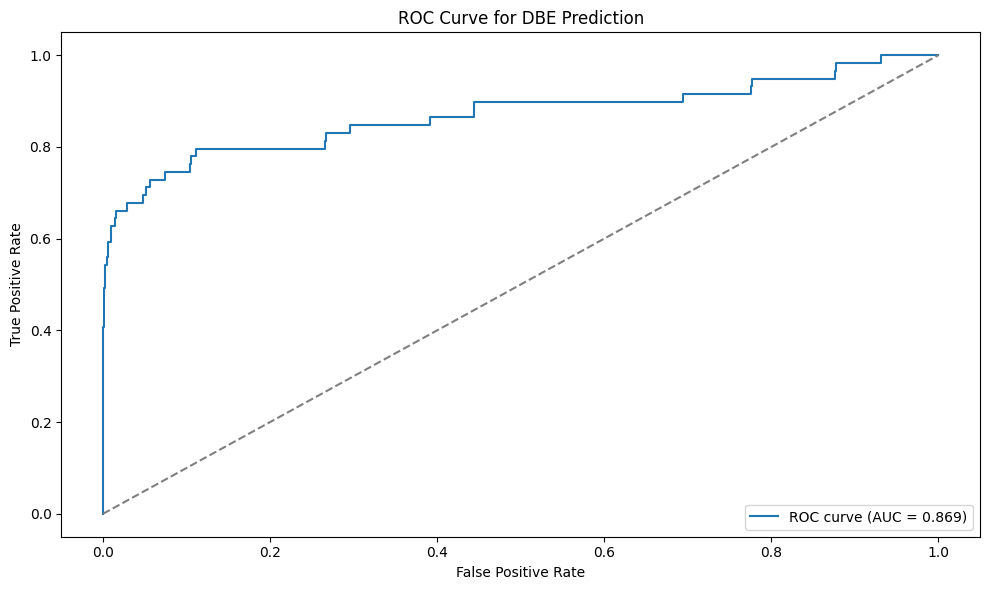

In [28]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for DBE Prediction")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The ROC curve compares the true positive rate and the false positive rate for different thresholds. The curve rises far above the diagonal baseline. The AUC score of about 0.869 shows that the model separates failure snapshots from normal snapshots with strong reliability.

<b>Key point to mention:</b><br/>
The model learns meaningful patterns in GPU telemetry. Even with rare failures, it maintains high separability between both classes.

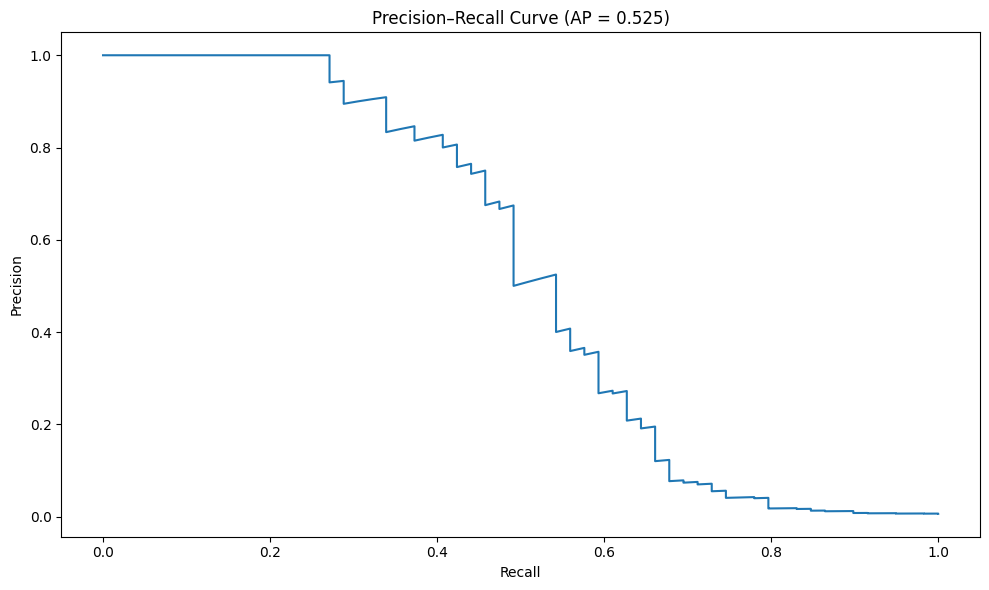

In [29]:
#Precision–Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The curve drops as recall increases. This is normal with rare events. The average precision score of about 0.525 shows that the model keeps reasonable precision while retrieving a large portion of failure cases.

<b>Key point to mention:</b><br/>
The curve highlights the tradeoff between catching more failures and producing more false alarms. This helps choose a threshold that fits proactive fault tolerance.

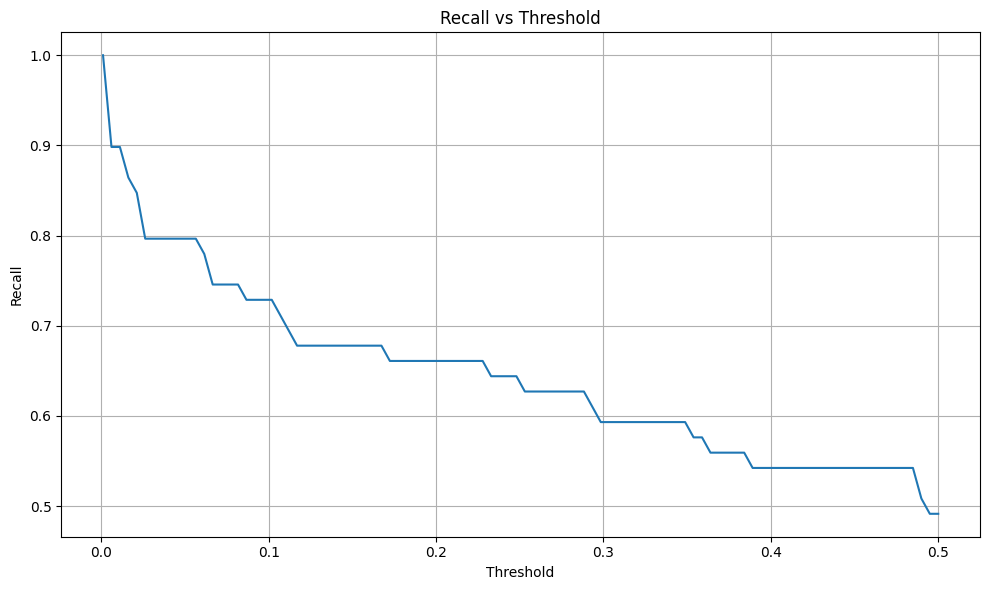

In [30]:
#Threshold vs Recall Plot

thresholds = np.linspace(0.001, 0.5, 100)
recalls = []

for t in thresholds:
    preds = (y_prob > t).astype(int)
    r = (preds[y_test==1]==1).mean()
    recalls.append(r)

plt.figure()
plt.plot(thresholds, recalls)
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
Recall drops as the threshold increases. Low thresholds produce high recall because the model marks more samples as failures. High thresholds reduce recall and miss many failures.

<b>Key point to mention:</b><br/>
This plot helps select an operating threshold. A threshold around 0.1 reaches about 0.73 recall and keeps the system usable, which fits proactive detection goals.

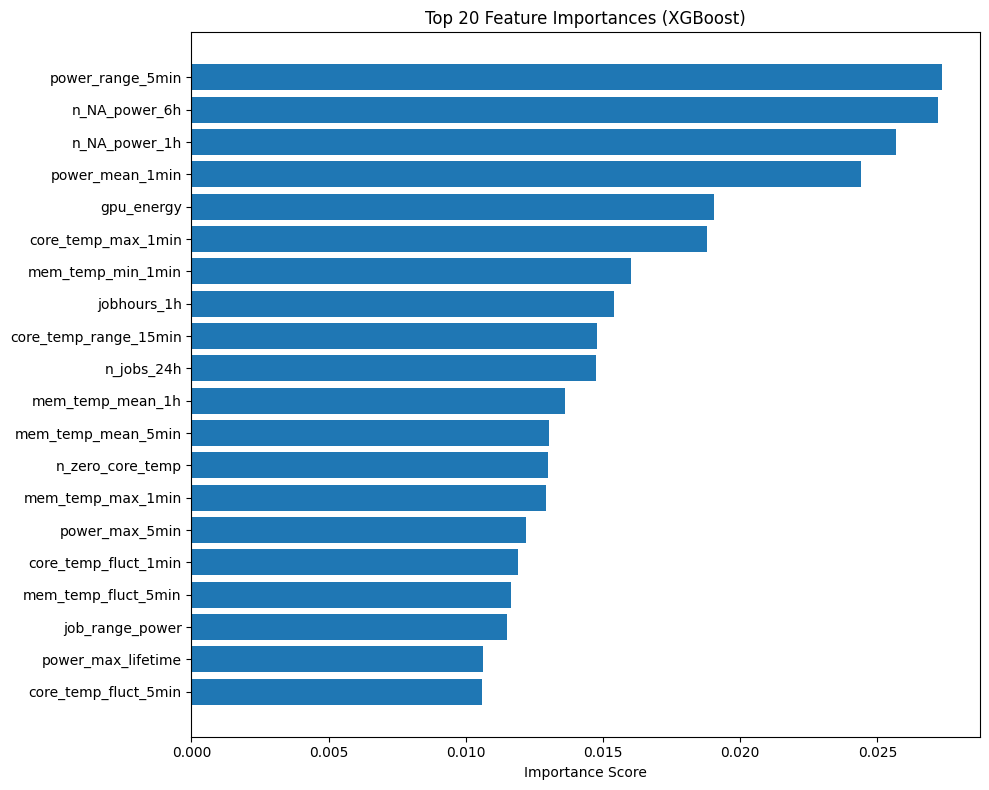

In [31]:
#Feature Importance (Top 20)
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10,8))
plt.barh(np.array(X.columns)[idx][::-1], importances[idx][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
The model ranks power and temperature instability features as the most predictive. Short-term changes in power and temperature, missing telemetry counts, and job-level power metrics appear at the top.

<b>Key point to mention:</b><br/>
These features capture stress patterns on GPU hardware. They align with known DBE behavior where thermal spikes, power fluctuations, and unstable sensor readings precede failures.

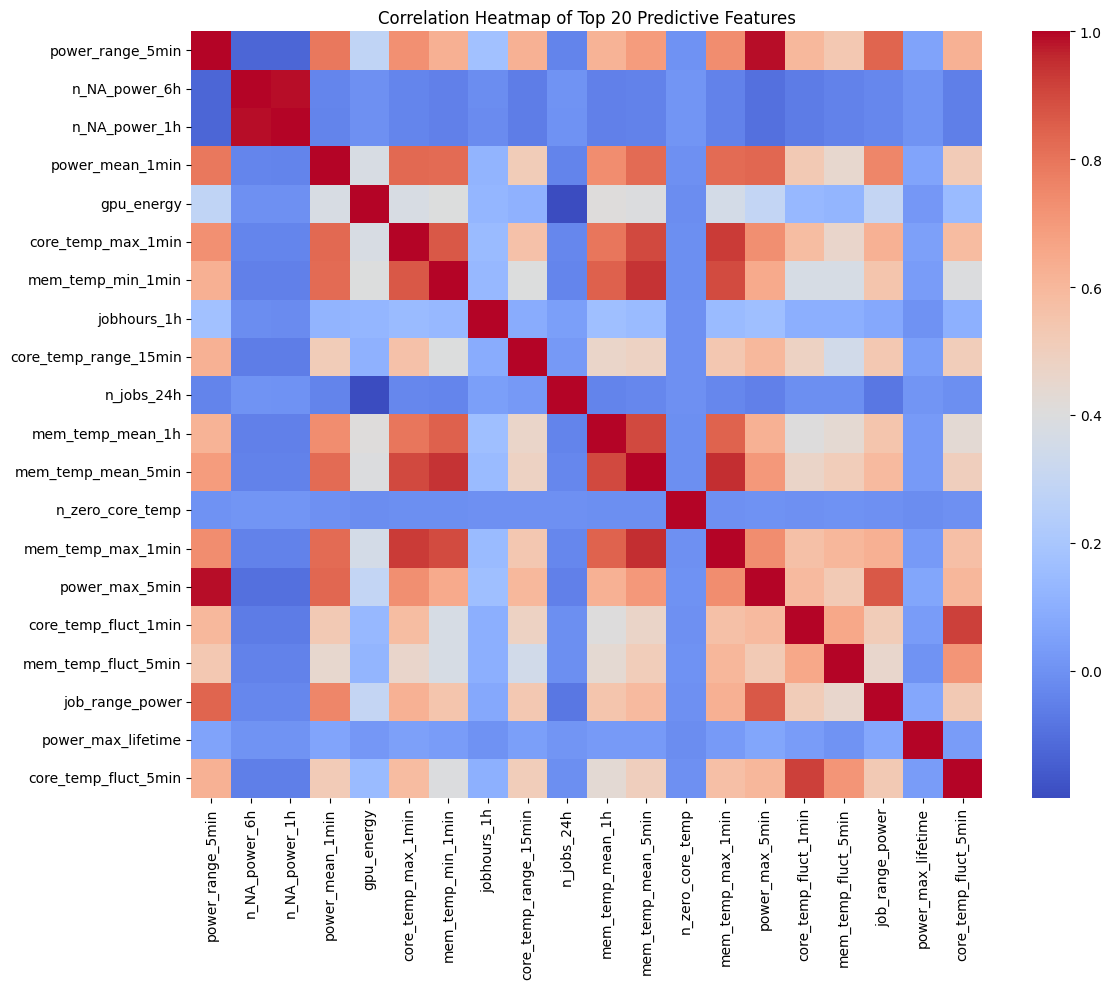

In [33]:
#Correlation Heatmap (Top 20 Features)
top20_features = X.columns[idx]

corr = X[top20_features].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Top 20 Predictive Features")
plt.tight_layout()
plt.show()

<b>What the plot shows:</b><br/>
Some temperature and power features show strong correlations. Short-term temperature features cluster together. Missing telemetry counts also correlate with each other.

<b>Key point to mention:</b><br/>
These relationships show that DBE-related signals do not appear in isolation. They reflect combined effects of thermal changes, power shifts, and unstable readings before a failure.